<a href="https://colab.research.google.com/github/raphael-fawaz/Financial-Markets-Analysis-and-Prediction/blob/Reinforcement-QLearning/QLearning_DJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jasonmayes/headless-chrome-nvidia-t4-gpu-support.git
!cd headless-chrome-nvidia-t4-gpu-support && chmod +x scriptyMcScriptFace.sh && ./scriptyMcScriptFace.sh

Cloning into 'headless-chrome-nvidia-t4-gpu-support'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 420 (delta 100), reused 232 (delta 93), pack-reused 172
Receiving objects: 100% (420/420), 105.41 KiB | 9.58 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 ht

In [ ]:

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Input
from keras.optimizers import Adam

import numpy as np
import random
from collections import deque

class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=1000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995

		self.model = load_model("models/" + model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Input(shape=(self.state_size,)))  # Define input shape
		model.add(Dense(units=64, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		optimizer = Adam(learning_rate=0.001)
		model.compile(loss="mse", optimizer=optimizer)

		return model

	def act(self, state):
		if not self.is_eval and random.random() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
		states = np.array([experience[0] for experience in mini_batch]).reshape(batch_size, self.state_size)
		next_states = np.array([experience[3] for experience in mini_batch]).reshape(batch_size, self.state_size)

		target_f = self.model.predict(states)
		target_next = self.model.predict(next_states)

		for i, (state, action, reward, next_state, done) in enumerate(mini_batch):
			target = reward if done else reward + self.gamma * np.amax(target_next[i])
			target_f[i][action] = target

		self.model.fit(states, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay

In [ ]:
import numpy as np
import math

from sklearn.preprocessing import StandardScaler

# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
	vec = []
	lines = open("/content/" + key + ".csv", "r").read().splitlines()

	for line in lines[1:]:
		vec.append(float(line.split(",")[4]))
	return np.array(vec)

def normalize_data(data):
	data = data.reshape(-1, 1)  # Ensure data is in the right shape for scalers
	robust_scaler = RobustScaler()
	data_robust_scaled = robust_scaler.fit_transform(data)
	standard_scaler = StandardScaler()
	normalized_data = standard_scaler.fit_transform(data_robust_scaled)
	return normalized_data.flatten(), robust_scaler, standard_scaler

# returns the sigmoid
def sigmoid(x):
    pos_mask = (x >= 0)
    neg_mask = (x < 0)

    pos_res = 1 / (1 + np.exp(-x[pos_mask]))
    neg_res = np.exp(x[neg_mask]) / (1 + np.exp(x[neg_mask]))

    result = np.zeros_like(x)
    result[pos_mask] = pos_res
    result[neg_mask] = neg_res

    return result

# returns an n-day state representation ending at time t
def getState(data, t, n):
    d = t - n + 1
    block = []
    if d >= 0:
        block = data[d:t + 1]
    else:
        block = [-d * data[0]] * abs(d) + list(data[0:t + 1])

    # Check if the block has enough elements
    if len(block) < n:
        return np.zeros((1, n - 1))

    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))

    return np.array(res).reshape(1, -1)

In [ ]:
# from agent.agent import Agent
# from functions import *
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler

# if len(sys.argv) != 4:
# 	print("Usage: python train.py [stock] [window] [episodes]")
# 	exit()

stock_name, window_size, episode_count = "dow_training", 10, 0

agent = Agent(window_size)
data = getStockDataVec(stock_name)

normalized_data, robust_scaler, standard_scaler = normalize_data(data)

l = len(normalized_data) - 1

batch_size = 64

profit_count = 0
sell_count = 0

for e in range(episode_count + 1):
	print("Episode {}/{}".format(e, episode_count))
	state = getState(normalized_data, 0, window_size + 1)

	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)
		# sit
		next_state = getState(data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(data[t])
			print("Buy: " + formatPrice(data[t]))

		elif action == 2 and len(agent.inventory) > 0: # sell
			sell_count += 1
			bought_price = agent.inventory.pop(0)
			reward = max(data[t] - bought_price, 0)
			total_profit += data[t] - bought_price
			if data[t] - bought_price > 0:
				profit_count+= 1
			print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print((profit_count/sell_count)*100)
			print("--------------------------------")
			print("Total Profit: " + formatPrice(total_profit))
			print("--------------------------------")

		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)

	if e % 10 == 0:
		agent.model.save("/content/models/model_ep" + str(e))

1/1 [==============================] - 0s 25ms/step
0
--------------------------------
dow_testing Total Profit: $0.00
--------------------------------


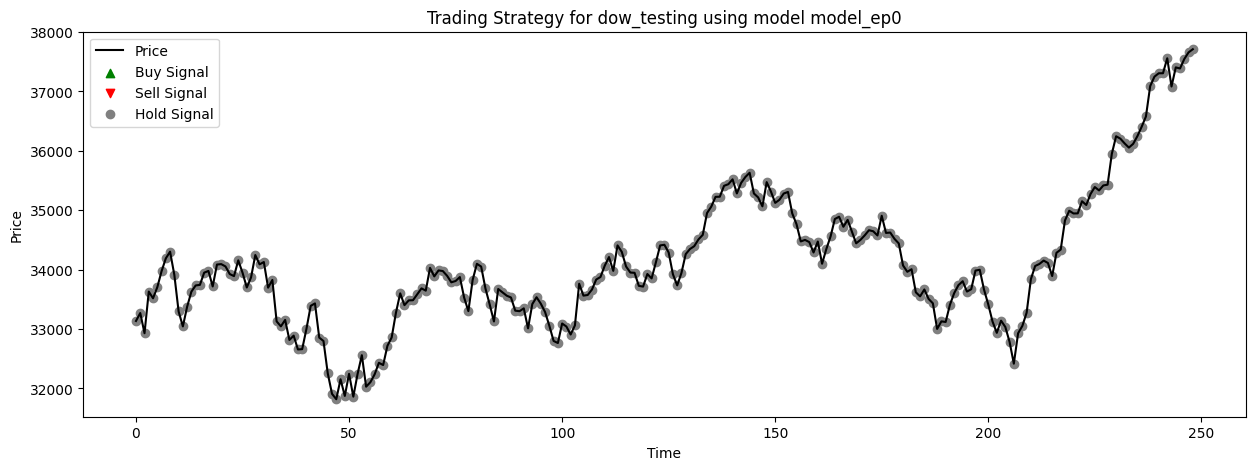

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from sklearn.preprocessing import RobustScaler, StandardScaler
from keras.models import load_model
from collections import deque


# if len(sys.argv) != 3:
#     print("Usage: python evaluate.py [stock] [model]")
#     exit()

stock_name, model_name = "dow_testing", "model_ep0"
model = load_model("models/" + model_name, compile=False)
window_size = model.input_shape[1]
agent = Agent(window_size, True, model_name)

data = getStockDataVec(stock_name)
normalized_data, robust_scaler, standard_scaler = normalize_data(data)

l = len(normalized_data) - 1
state = getState(data, 0, window_size + 1)

total_profit = 0
agent.inventory = []
actions = []
prices = []
profits = []

sell_count = 0

for t in range(l):

    action = agent.act(state)
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0

    if action == 1:  # buy
        agent.inventory.append(data[t])
        print("Buy: " + formatPrice(float(data[t])))
        actions.append('buy')
    elif action == 2 and len(agent.inventory) > 0:  # sell
        sell_count += 1
        bought_price = agent.inventory.pop(0)
        profit = data[t] - bought_price
        total_profit += profit
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(profit))
        actions.append('sell')
        profits.append(profit)
    else:
        actions.append('hold')

    prices.append(data[t])
    state = next_state

print(sell_count)
print("--------------------------------")
print(stock_name + " Total Profit: " + formatPrice(total_profit))
print("--------------------------------")


def plot_results(prices, actions, model_name):
    plt.figure(figsize=(15, 5))
    plt.plot(prices, label='Price', color='black')

    buy_signals = [i for i, action in enumerate(actions) if action == 'buy']
    sell_signals = [i for i, action in enumerate(actions) if action == 'sell']
    hold_signals = [i for i, action in enumerate(actions) if action == 'hold']

    plt.scatter(buy_signals, [prices[i] for i in buy_signals], marker='^', color='green', label='Buy Signal', alpha=1)
    plt.scatter(sell_signals, [prices[i] for i in sell_signals], marker='v', color='red', label='Sell Signal', alpha=1)
    plt.scatter(hold_signals, [prices[i] for i in hold_signals], marker='o', color='gray', label='Hold Signal', alpha=1)

    plt.title(f"Trading Strategy for {stock_name} using model {model_name}")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_results(prices, actions, model_name)
